# Problem Statement

1. Top Areas with the highest number of listing
2. Thematic Map of the neighbourhood - broken down by single room, entire home.
3. Top 10 hosts by their total number of listings.
4. Personal Metric.




In [1]:
import pandas as pd 
import numpy as np 
import geopandas as gpd 

In [2]:
listings = pd.read_csv("data/listings.csv")
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2265,Zen-East in the Heart of Austin (monthly rental),2466,Paddy,NaN,78702,30.27750,-97.71398,Entire home/apt,200,7,24,2019-03-16,0.17,3,131
1,5245,"Eco friendly, Colorful, Clean, Cozy monthly share",2466,Paddy,NaN,78702,30.27577,-97.71379,Private room,114,30,9,2018-03-14,0.06,3,0
2,5456,"Walk to 6th, Rainey St and Convention Ctr",8028,Sylvia,NaN,78702,30.26112,-97.73448,Entire home/apt,104,2,543,2021-02-01,3.74,1,354
3,5636,"Soco, Barton Springs Private Guest Cottage",7148,Peggy,NaN,78704,30.24630,-97.76361,Entire home/apt,46,30,21,2020-11-06,0.15,2,67
4,5769,NW Austin Room,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,39,1,259,2021-02-10,1.96,1,79


In [3]:
host_names = list(listings['host_name'])
host_ids = list(listings['host_id'])
unique_host_ids = np.unique(host_ids)
room_types = list(listings['room_type'])
print(f"There are {len(unique_host_ids)} unique host IDs")
u_room_types = np.unique(list(listings['room_type']))
print(f"Room types - {u_room_types}")
print(f"Total samples : {len(host_names)}")


There are 6773 unique host IDs
Room types - ['Entire home/apt' 'Hotel room' 'Private room' 'Shared room']
Total samples : 10272


## #1 Top Areas by Listings

In [4]:
neighbourhoods = list(listings['neighbourhood'])
unique_neighbourhoods = np.unique(neighbourhoods)
listings_by_neighbourhood = {n:0 for n in unique_neighbourhoods}
listings_count = list(listings["calculated_host_listings_count"])

for i, lst in enumerate(listings_count):
    listings_by_neighbourhood[neighbourhoods[i]]+=lst 

sorted_neighbourhood_tuples = sorted(listings_by_neighbourhood.items(), key = lambda x : x[1])
print("Top 10 Neighbourhoods by Listings - \n")
print("Neighbourhood | Listings")
print("~"*len("Neighbourhood | Listings"))
for x, y in (sorted_neighbourhood_tuples[-10:][::-1]):
    print(x, "        |", y)


Top 10 Neighbourhoods by Listings - 

Neighbourhood | Listings
~~~~~~~~~~~~~~~~~~~~~~~~
78745         | 26733
78751         | 23334
78758         | 22029
78735         | 20357
78702         | 19429
78701         | 15938
78704         | 13740
78729         | 10191
78754         | 6326
78717         | 6299


In [5]:
import matplotlib.pyplot as plt
geoframe = gpd.read_file("data/neighbourhoods.geojson")
geoframe.head()

,neighbourhood,neighbourhood_group,geometry
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ..."
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ..."
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ..."
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ..."
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ..."


In [6]:
geo_listings_by_nbd = []
for nbd in list(geoframe['neighbourhood']):
    geo_listings_by_nbd.append(listings_by_neighbourhood[int(nbd)])
geoframe['nbd_listings'] = geo_listings_by_nbd
geoframe.head()

,neighbourhood,neighbourhood_group,geometry,nbd_listings
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",28
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ...",6326
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ...",327
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ...",550
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ...",1568


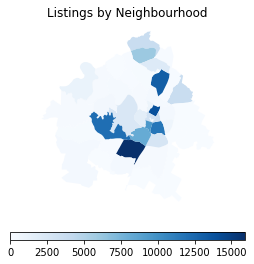

In [7]:
geoframe.plot(column='nbd_listings', cmap='Blues')
plt.axis("off")
plt.title("Listings by Neighbourhood")
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=15938))
# empty array for the data range
sm.set_array([])
plt.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
plt.savefig("maps/nbd_listings.png", dpi=300)
plt.show()

## #2 Thematic Map

In [8]:
# Getting listings by room_type
# Room types - ['Entire home/apt' 'Hotel room' 'Private room' 'Shared room']
nbd_entire = nbd_hotel = nbd_private = nbd_shared = {nbd:0 for nbd in unique_neighbourhoods}
for i, lst in enumerate(listings_count):
    # print(room_types[i])
    if room_types[i] == "Entire home/apt":
        nbd_entire[neighbourhoods[i]] += lst
        continue
    elif room_types[i] == "Hotel room":
        nbd_hotel[neighbourhoods[i]] += lst
        continue
    elif room_types[i] == "Private room":
        nbd_private[neighbourhoods[i]] += lst
        continue
    elif room_types[i] == "Shared room":
        nbd_shared[neighbourhoods[i]] += lst
        continue

geoframe['lst_entire'] = [nbd_entire[int(nbd)] for nbd in list(geoframe['neighbourhood'])]
geoframe['lst_hotel'] = [nbd_hotel[int(nbd)] for nbd in list(geoframe['neighbourhood'])]
geoframe['lst_private'] = [nbd_private[int(nbd)] for nbd in list(geoframe['neighbourhood'])]
geoframe['lst_shared'] = [nbd_shared[int(nbd)] for nbd in list(geoframe['neighbourhood'])]


geoframe.head() 


,neighbourhood,neighbourhood_group,geometry,nbd_listings,lst_entire,lst_hotel,lst_private,lst_shared
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",28,28,28,28,28
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ...",6326,6326,6326,6326,6326
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ...",327,327,327,327,327
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ...",550,550,550,550,550
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ...",1568,1568,1568,1568,1568


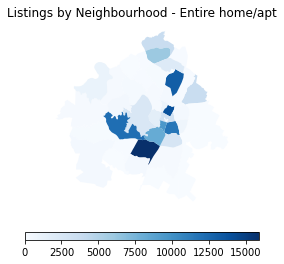

In [9]:
geoframe.plot(column='lst_entire', cmap='Blues')
plt.axis("off")
plt.title("Listings by Neighbourhood - Entire home/apt")
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=15938))
# empty array for the data range
sm.set_array([])
plt.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
plt.savefig("maps/lst_entire.png", dpi=300)
plt.show()

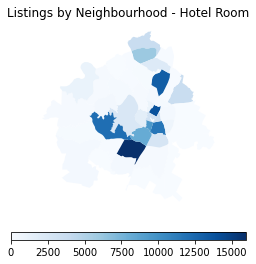

In [10]:
geoframe.plot(column='lst_hotel', cmap='Blues')
plt.axis("off")
plt.title("Listings by Neighbourhood - Hotel Room")
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=15938))
# empty array for the data range
sm.set_array([])
plt.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
plt.savefig("maps/lst_hotel.png", dpi=300)
plt.show()

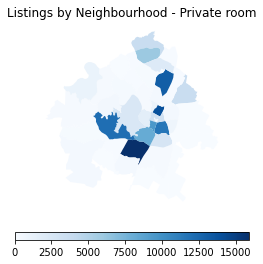

In [11]:
geoframe.plot(column='lst_private', cmap='Blues')
plt.axis("off")
plt.title("Listings by Neighbourhood - Private room")
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=15938))
# empty array for the data range
sm.set_array([])
plt.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
plt.savefig("maps/lst_private.png", dpi=300)
plt.show()

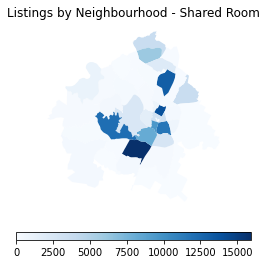

In [12]:
geoframe.plot(column='lst_shared', cmap='Blues')
plt.axis("off")
plt.title("Listings by Neighbourhood - Shared Room")
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=15938))
# empty array for the data range
sm.set_array([])
plt.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
plt.savefig("maps/lst_shared.png", dpi=300)
plt.show()

## #3 Top 10 Hosts

In [13]:
listings_count = list(listings["calculated_host_listings_count"])
host_listings = {id:0 for id in unique_host_ids}
for i in range(len(listings_count)):
    host_listings[host_ids[i]]+=listings_count[i]

sorted_tuples = sorted(host_listings.items(), key=lambda x : x[1])

In [14]:
print("The top 10 hosts by listings are : ")
id10, lst10, name10 = [], [], []
for x in sorted_tuples[-10:][::-1]:
    id, lst = x
    id10.append(id); lst10.append(lst)
    name = host_names[host_ids.index(id)]
    name10.append(name)
top10_df = pd.DataFrame(data = {"Host_ID":id10, "Name": name10,  "Listings":lst10})
top10_df.head(10)

The top 10 hosts by listings are : 


,Host_ID,Name,Listings
0,359036978,Kia,128164
1,104309976,WanderJaunt,17161
2,109638288,TurnKey Vacation Rentals,6724
3,8167447,Martin,6561
4,118565935,Renters Club,3136
5,346827202,Madalynn,2304
6,194953121,Christian,2025
7,210733801,Above,1849
8,368944610,Kia,1600
9,124060715,Evolve Vacation Rental,1444


## #4 Personal Metric
